## Online Retail Sales EDA – Customer Behavior & Sales Analysis

#####  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


#####  Load Dataset & Initial Exploration

Loading the Online Retail dataset and displaying its first few rows.

In [2]:
# load dataset
df = pd.read_excel('online_retail.xlsx')

# First few rows 
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Checking the number of rows and columns in the dataset.

In [3]:
df.shape

(525461, 8)


The dataset contains **525461** rows and **8** columns.

Viewing the data types of each column to understand how the data is stored.

In [4]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

Getting a summary of the dataset including column names, non-null counts, and data types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Generating descriptive statistics for numeric and datetime columns in the dataset.

In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


📌 Observation:

Quantity and Price have extreme values (e.g., Quantity min = -9600, Price min = -53594.36) which indicate potential outliers or data entry errors.

Customer ID has missing values, as seen from the count being lower than other columns.

The average order quantity is around 10.33, and the median is 3, suggesting a right-skewed distribution.

InvoiceDate ranges from 2009-12-01 to 2010-12-09, covering about one year.

#####  Data Cleaning & Preprocessing

Calculating the percentage of missing values in each column.

In [7]:
(df.isnull().sum() / len(df))*100

Invoice         0.000000
StockCode       0.000000
Description     0.557225
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.539488
Country         0.000000
dtype: float64

📌 Observation:

Customer ID has 20.54% missing values — significant enough to consider imputation or exclusion.

Description has 0.56% missing values — relatively minor and can be imputed with a placeholder.

All other columns have 0% missing data.

Removing rows with missing Customer ID and filling missing Description values with a placeholder.

In [8]:
# Drop rows with missing Customer ID (and assign back to original df)
df = df[df['Customer ID'].notna()].copy()

# Now safely fill missing Description values
df['Description'] = df['Description'].fillna('Missing Description')

# Optional: check again for missing values
print(df.isnull().mean() * 100)

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64


📌 Observation:

All missing values have been handled.

The dataset now contains 0% missing values across all columns.

Removing duplicate rows from the dataset while keeping the first occurrence.

In [9]:
# Remove duplicate rows (keep the first occurrence)
df = df.drop_duplicates()

# Optional: Check shape to confirm duplicates removed
print("Data shape after removing duplicates:", df.shape)

Data shape after removing duplicates: (410763, 8)


📌 Observation:

Duplicate entries were successfully removed.

The dataset now has 410763 rows, ensuring cleaner and more reliable analysis.



Retrieving all unique invoice numbers to explore the types of transactions recorded.

In [10]:
df['Invoice'].value_counts().index

Index([   500356,    507235,    526089,    511522,    511051,    531382,
          525928,    532993,    534187,    493812,
       ...
          517197, 'C517219', 'C530287', 'C530285', 'C530284', 'C530282',
       'C530279',    517214,    517215, 'C503745'],
      dtype='object', name='Invoice', length=23587)

📌 Observation:

Some invoice numbers start with 'C', which typically indicates canceled orders and should be handled in the next step.

Invoices starting with 'C' represent canceled orders, which are removed from the dataset

In [11]:
# Step 1: Ensure Invoice column is treated as string
df['Invoice'] = df['Invoice'].astype(str)

# Step 2: Remove rows where Invoice starts with 'C'
df = df[~df['Invoice'].str.startswith('C')]

# Optional: Check shape after removing
print("Shape after removing canceled orders:", df.shape)


Shape after removing canceled orders: (400947, 8)


📌 Observation:

All canceled transactions have been successfully removed.

The dataset now includes only valid sales invoices.

Using the Interquartile Range (IQR) method to identify outliers in Quantity and Price.

In [12]:
def check_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    print(f"Outliers in {column}: {outliers.shape[0]}")

# Check outliers in Quantity and Price
check_outliers_iqr('Quantity')
check_outliers_iqr('Price')


Outliers in Quantity: 26296
Outliers in Price: 32623


📌 Observation:

Identified extreme values in both Quantity and Price columns.

Capping extreme values in Quantity and Price columns to their respective IQR limits to reduce the influence of outliers.

In [13]:
def cap_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Clip values to within the IQR bounds
    df[column] = df[column].clip(lower=lower, upper=upper)

# Apply capping to Quantity and Price
cap_outliers('Quantity')
cap_outliers('Price')

# Optional: Check if any outliers remain using IQR check again
# (should be 0 or very few due to exact bounds)


📌 Observation:

Outliers in Quantity and Price have been capped to acceptable ranges.

This preserves all rows while preventing skewed analysis due to extreme values.

Verifying if any Quantity or Price values are still negative after capping.

In [14]:
print("Invalid Quantity values (<= 0):", (df['Quantity'] <= 0).sum())
print("Invalid Price values (<= 0):", (df['Price'] <= 0).sum())

Invalid Quantity values (<= 0): 0
Invalid Price values (<= 0): 31


Observation:
All Quantity values are clean — no zero or negative values.

There are 31 records with Price <= 0, which are considered invalid for sales analysis.

remove these invalid price rows:

In [15]:
df = df[df['Price'] > 0]

#####  General Overview of the Dataset

In [16]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['axes.facecolor'] = 'white'

Counting the number of unique products using the StockCode column and visualizing the result.

Unique products: 4017


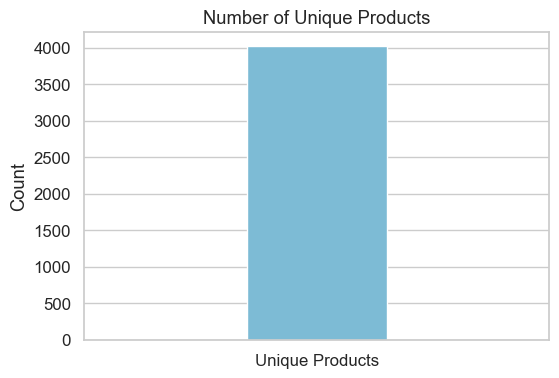

In [17]:
# Count unique products using StockCode
unique_products = df['StockCode'].nunique()
print("Unique products:", unique_products)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Unique Products'], y=[unique_products], palette=["#6EC1E4"], width=0.3)
plt.title('Number of Unique Products')
plt.ylabel('Count')
plt.show()


📌 Observation:

The dataset contains **4017** unique products.

Counting the number of unique transactions using the Invoice column and visualizing the result.

Total Transactions (Invoices): 19213


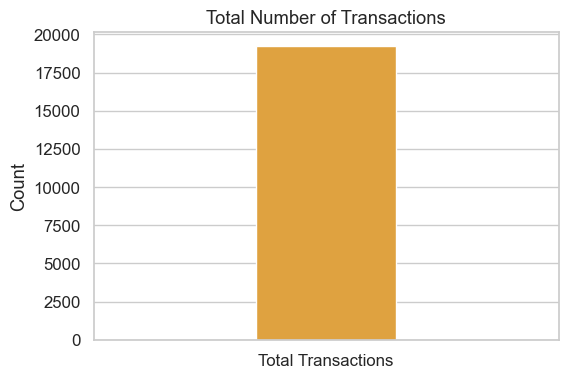

In [18]:
# Count unique invoices
total_transactions = df['Invoice'].nunique()
print("Total Transactions (Invoices):", total_transactions)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Total Transactions'], y=[total_transactions], palette=["#F9A825"], width=0.3)
plt.title('Total Number of Transactions')
plt.ylabel('Count')
plt.show()


📌 Observation:

There are **19215** unique transactions in the dataset.

Counting the number of unique customers using the Customer ID column and visualizing the result.

Unique Customers: 4312


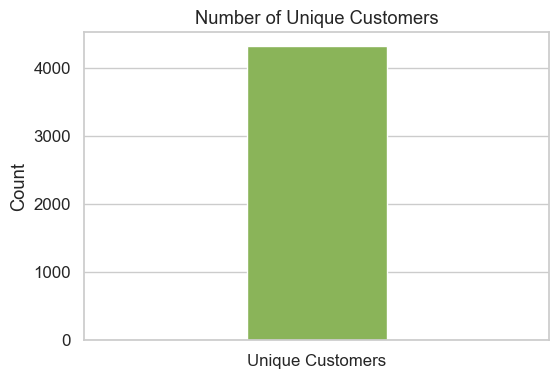

In [19]:
# Count unique customers
unique_customers = df['Customer ID'].nunique()
print("Unique Customers:", unique_customers)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Unique Customers'], y=[unique_customers], palette=["#8BC34A"], width=0.3)
plt.title('Number of Unique Customers')
plt.ylabel('Count')
plt.show()


📌 Observation:

The dataset contains **4314** unique customers, indicating the size of the customer base.

Analyzing which countries have the highest number of transactions and visualizing the top 10.

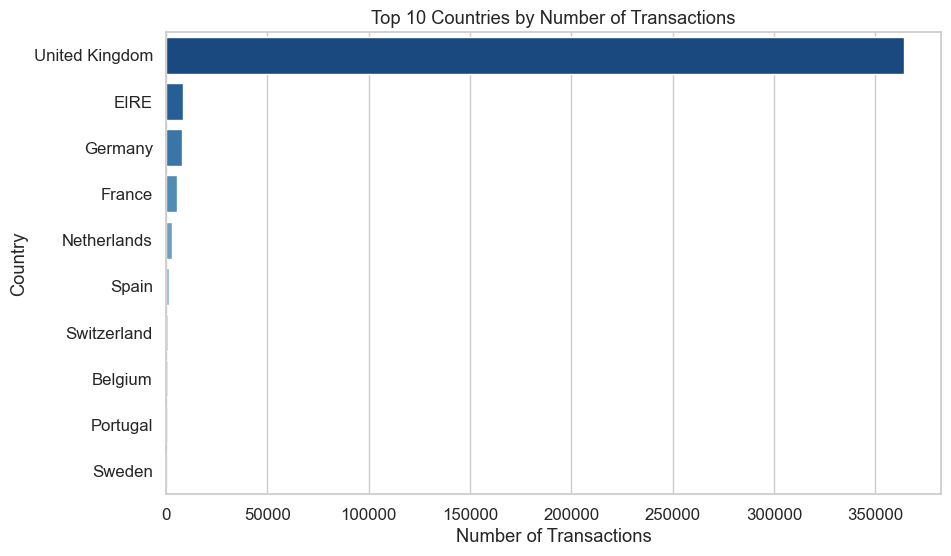

In [20]:
# Count customers by country
country_counts = df['Country'].value_counts().sort_values(ascending=False)

# Plot top 10 countries
plt.figure(figsize=(10,6))
sns.barplot(y=country_counts.head(10).index, x=country_counts.head(10).values, palette="Blues_r")
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()


📌 Observation:

The United Kingdom typically has the highest number of transactions.

Other countries like EIRE, Germany, France , Netherlands and Spain also contribute significantly.

#####  Product Analysis

Identifying the top 10 products with the highest total quantity sold.

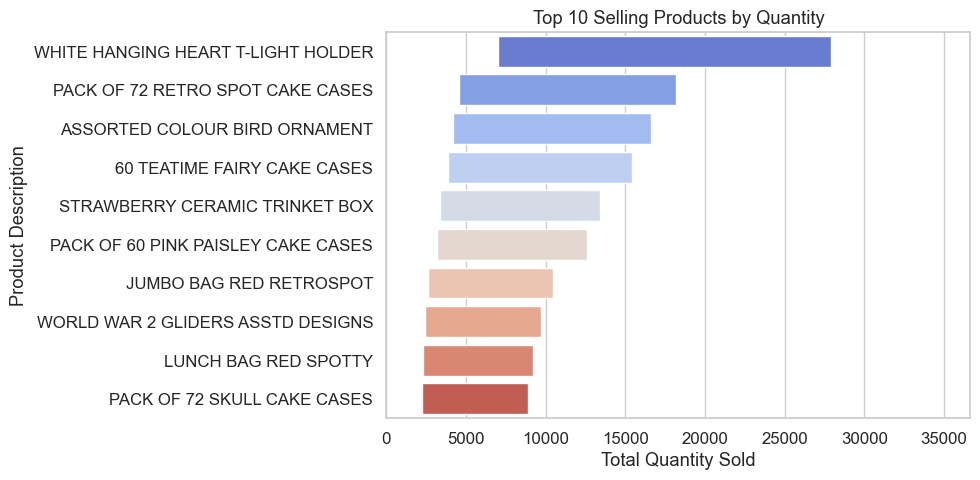

In [21]:
# Group by Description and sum Quantity
top_selling = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_selling.values, y=top_selling.index, palette='coolwarm')

# Slim the bars
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)

plt.title('Top 10 Selling Products by Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


📌 Observation:

The top products are high-demand items that significantly contribute to total sales volume.

Helps in identifying bestsellers and stocking decisions.

Calculating revenue (Quantity × Price) and identifying the products that generated the most revenue.

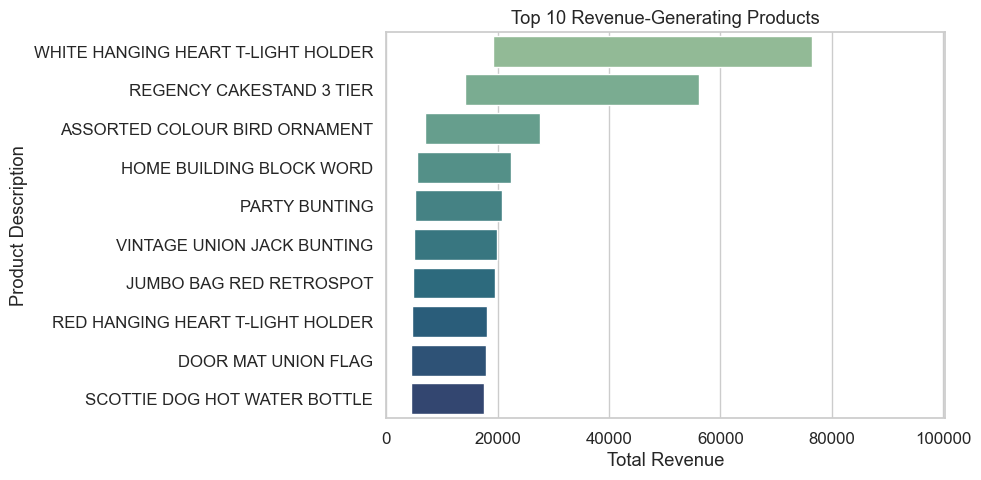

In [22]:
# Create Revenue column
df['Revenue'] = df['Quantity'] * df['Price']

# Group by Description and sum Revenue
top_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_revenue.values, y=top_revenue.index, palette='crest')

# Slim the bars
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)

plt.title('Top 10 Revenue-Generating Products')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


📌 Observation:

These top products contribute the highest total revenue, not necessarily the highest quantity.

Great insight for pricing and marketing strategies.

#####  Customer Analysis

Identifying the top 10 customers who bought the most number of items overall.

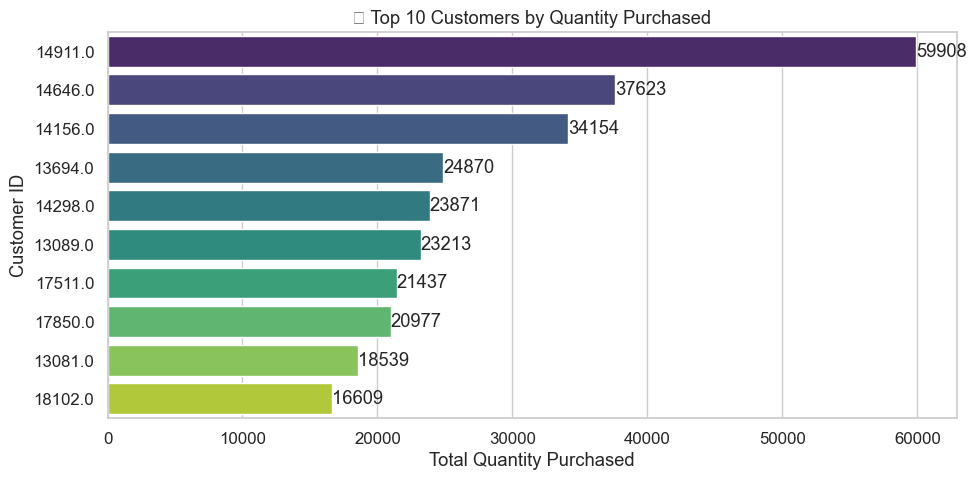

In [23]:
# Top 10 customers by quantity purchased
top_customers = df.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_customers.values, y=top_customers.index.astype(str), palette="viridis")

# Add quantity labels at end of each bar
for i, (value, name) in enumerate(zip(top_customers.values, top_customers.index)):
    plt.text(value + 1, i, str(value), va='center')

plt.title('👥 Top 10 Customers by Quantity Purchased')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


📌 Observation:

These customers purchased the highest total quantity of products.

They can be considered high-value bulk buyers.

Analyzing how frequently customers make purchases by counting the number of unique invoices per customer.

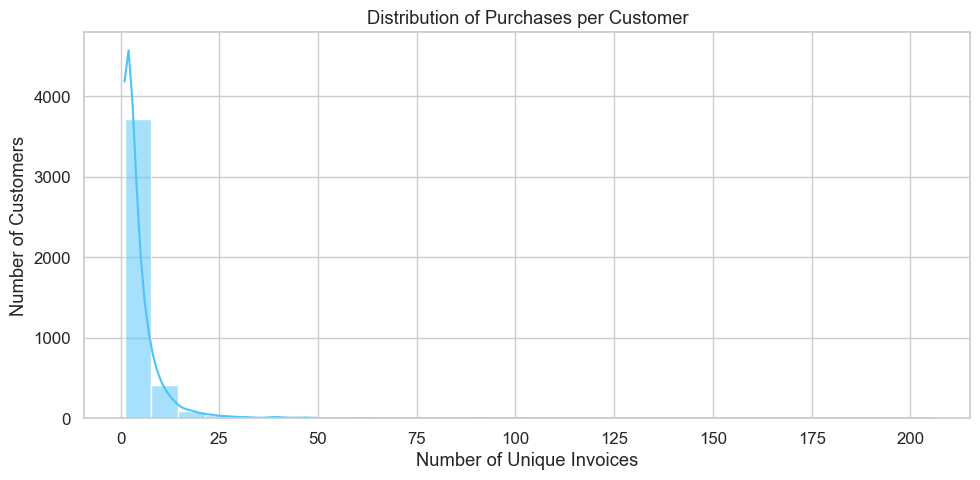

In [24]:
# Count number of purchases (invoices) per customer
purchases_per_customer = df.groupby('Customer ID')['Invoice'].nunique()

# Plot
plt.figure(figsize=(10,5))
sns.histplot(purchases_per_customer, bins=30, kde=True, color='#4FC3F7')
plt.title('Distribution of Purchases per Customer')
plt.xlabel('Number of Unique Invoices')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


📌 Observation:

Most customers make fewer purchases, with only a small group showing frequent buying behavior.

Identifying customers who made more than 50 unique purchases (invoices), and visualizing the top 10 among them.

Number of loyal customers: 18
Customer ID
14911.0    205
17850.0    155
12748.0    144
15311.0    121
13089.0    109
14156.0    102
14606.0    102
13694.0     94
17841.0     91
18102.0     89
Name: Invoice, dtype: int64


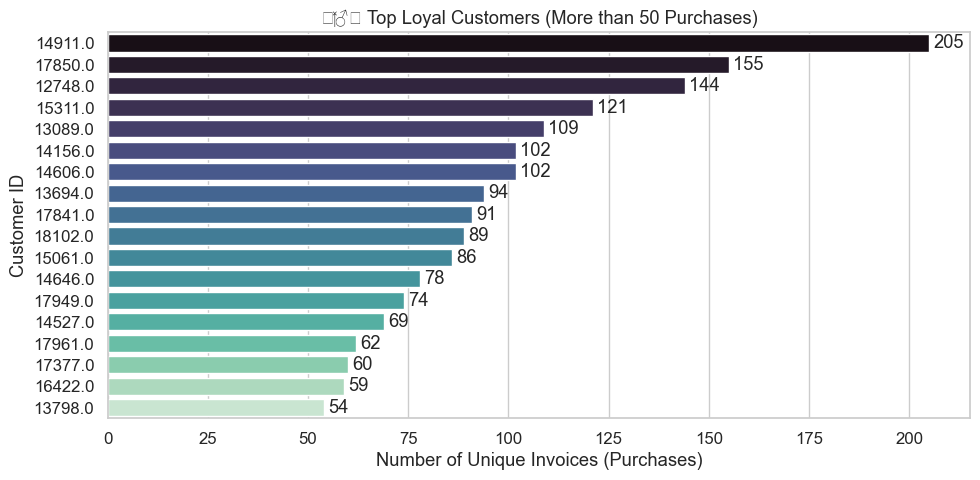

In [25]:
# Find loyal customers (more than 50 unique invoices)
purchases_per_customer = df.groupby('Customer ID')['Invoice'].nunique()
loyal_customers = purchases_per_customer[purchases_per_customer > 50]

print("Number of loyal customers:", loyal_customers.shape[0])
print(loyal_customers.sort_values(ascending=False).head(10))

# Plot Top 10 loyal customers
top_loyal = loyal_customers.sort_values(ascending=False).head(50)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_loyal.values, y=top_loyal.index.astype(str), palette="mako")

# Add text labels on bars
for i, (value, name) in enumerate(zip(top_loyal.values, top_loyal.index)):
    plt.text(value + 1, i, str(value), va='center')

plt.title('🧍‍♂️ Top Loyal Customers (More than 50 Purchases)')
plt.xlabel('Number of Unique Invoices (Purchases)')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


📌 Observation:

**18** customers made more than 50 purchases, showing strong loyalty.

The chart highlights the top 10 loyal customers, ideal for retention strategies or rewards.

#####  Time Series & Seasonal Trends

Creating a time series plot to visualize how revenue changes over different months.

In [26]:
# Create Revenue column
df['Revenue'] = df['Quantity'] * df['Price']

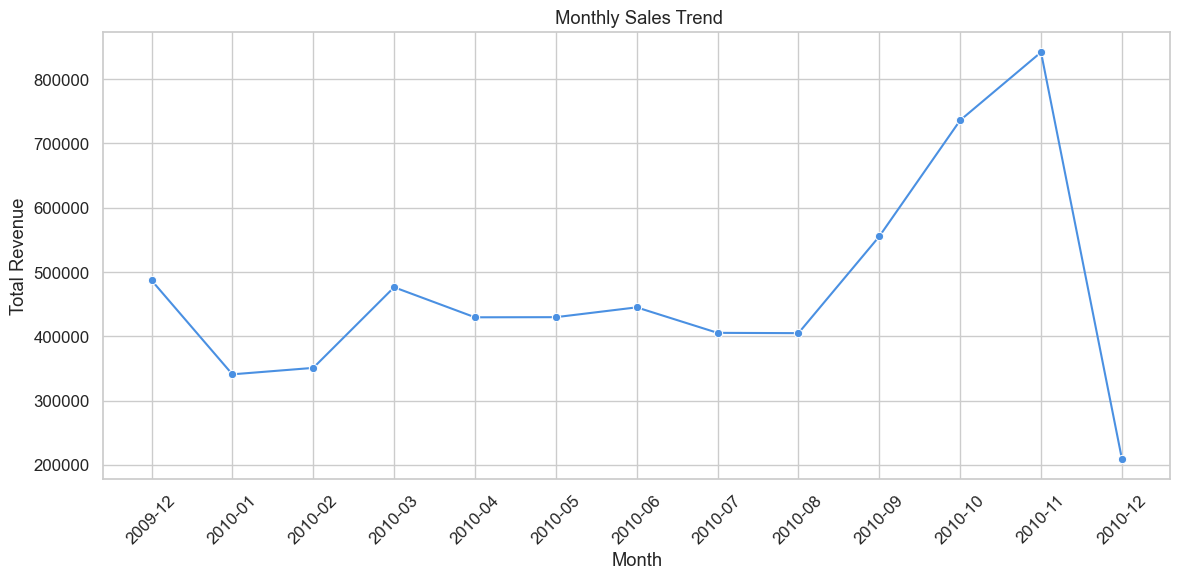

In [27]:
# Extract Year-Month from InvoiceDate
df['Month'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Group by Month and sum revenue
monthly_sales = df.groupby('Month')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Revenue', marker='o', color="#4A90E2")
plt.xticks(rotation=45)
plt.title(' Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


📌 Observation:

Sales exhibit seasonal patterns, with certain months showing higher revenue.

This trend helps in understanding peak business periods and slow months for better planning.


Analyzing how the number of unique transactions varies across different days of the week.

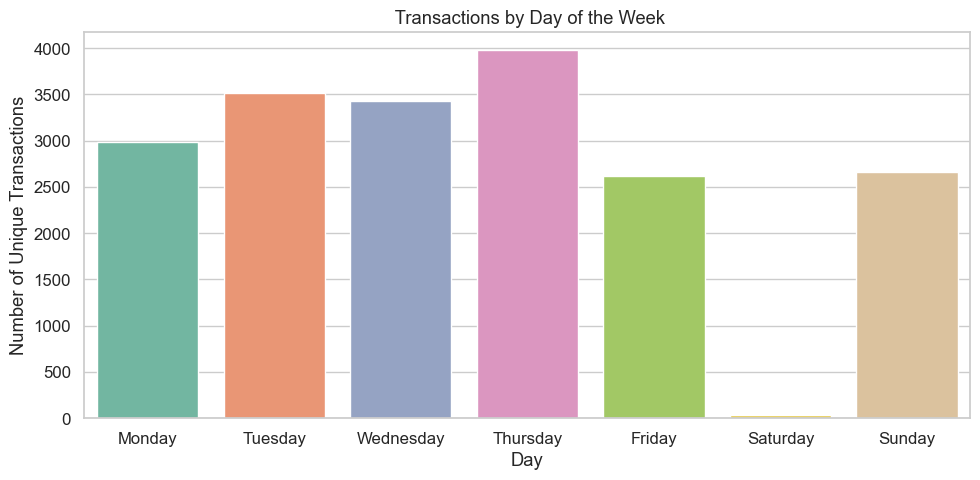

In [28]:
# Extract day of week (Monday = 0, Sunday = 6)
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Group by DayOfWeek and count transactions
daily_orders = df.groupby('DayOfWeek')['Invoice'].nunique().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=daily_orders.index, y=daily_orders.values, palette="Set2")
plt.title(' Transactions by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Unique Transactions')
plt.tight_layout()
plt.show()


📌 Observation:

Certain weekdays, like **Thursday**, show higher customer activity, while **Saturday** are relatively slower.

Helps in optimizing staffing and promotions based on traffic trends.

In [29]:
# Sort to find peak and slow months
peak_month = monthly_sales.sort_values(by='Revenue', ascending=False).iloc[0]
slow_month = monthly_sales.sort_values(by='Revenue').iloc[0]

print("🔼 Peak Month:", peak_month['Month'], "→ Revenue:", round(peak_month['Revenue'], 2))
print("🔽 Slow Month:", slow_month['Month'], "→ Revenue:", round(slow_month['Revenue'], 2))

🔼 Peak Month: 2010-11 → Revenue: 841853.52
🔽 Slow Month: 2010-12 → Revenue: 209779.71


This step visualizes monthly revenue trends and highlights the peak and slowest sales months using annotations.

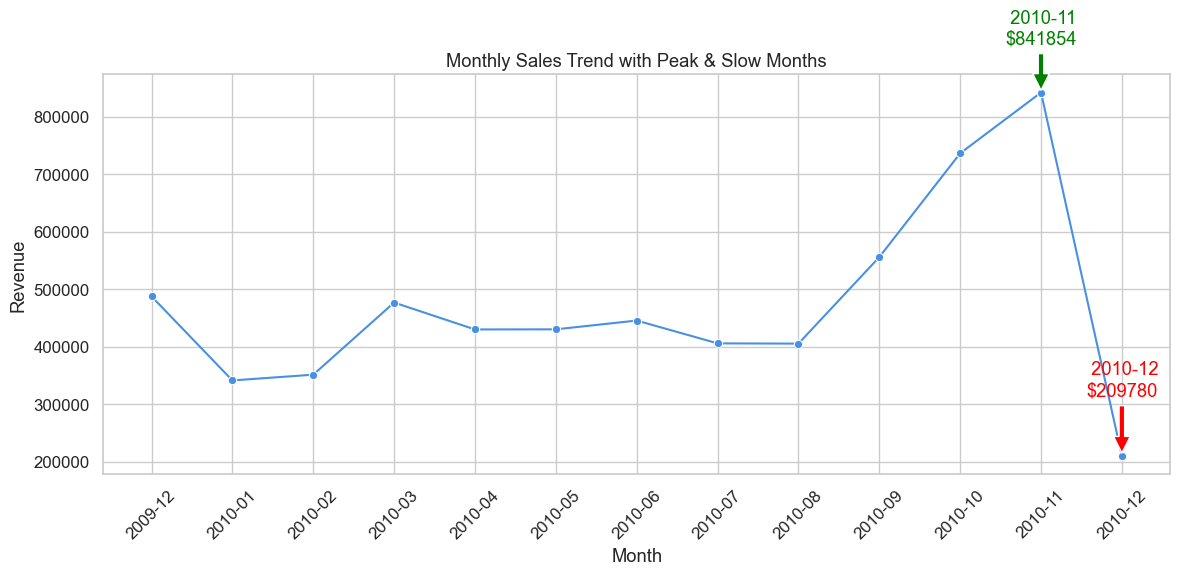

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create Revenue and Month columns
df['Revenue'] = df['Quantity'] * df['Price']
df['Month'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Group by Month
monthly_sales = df.groupby('Month')['Revenue'].sum().reset_index()

# Find peak and slow months
peak = monthly_sales.loc[monthly_sales['Revenue'].idxmax()]
slow = monthly_sales.loc[monthly_sales['Revenue'].idxmin()]

# Plot with annotations
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Revenue', marker='o', color="#4A90E2")

plt.annotate(f" {peak['Month']}\n${peak['Revenue']:.0f}",
             xy=(peak['Month'], peak['Revenue']),
             xytext=(peak['Month'], peak['Revenue']*1.1),
             arrowprops=dict(facecolor='green', shrink=0.05),
             color='green', ha='center')

plt.annotate(f" {slow['Month']}\n${slow['Revenue']:.0f}",
             xy=(slow['Month'], slow['Revenue']),
             xytext=(slow['Month'], slow['Revenue']*1.5),
             arrowprops=dict(facecolor='red', shrink=0.05),
             color='red', ha='center')

plt.xticks(rotation=45)
plt.title("Monthly Sales Trend with Peak & Slow Months")
plt.tight_layout()
plt.show()


📌 Observation:

Peak Month: **11** with revenue $841854

Slow Month: **12** with revenue $209780

This helps identify the best periods for marketing and restocking efforts.

#####  Country-wise Sales Analysis

This step identifies the top 10 countries based on the number of unique orders placed, giving insights into the geographic distribution of customers.

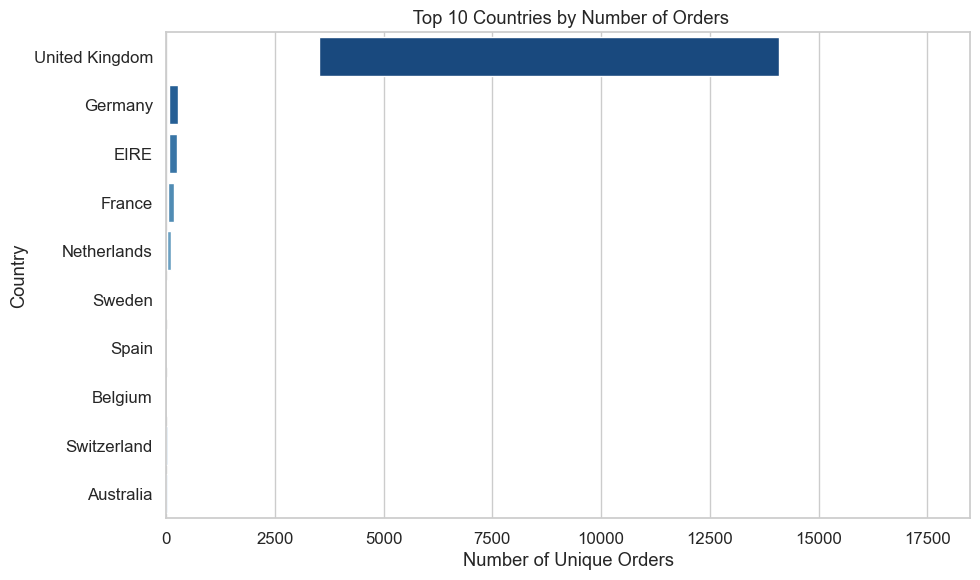

In [31]:
# Count unique invoices per country
orders_by_country = df.groupby('Country')['Invoice'].nunique().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=orders_by_country.values, y=orders_by_country.index, palette="Blues_r")

# Slim the bars
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)

plt.title(" Top 10 Countries by Number of Orders")
plt.xlabel("Number of Unique Orders")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


📌 Observation:

The United Kingdom leads by a wide margin, followed by other European countries.

This suggests the store's operations are highly centered around the UK region.

This step calculates the total revenue generated from each country and visualizes the top 10 countries by sales value

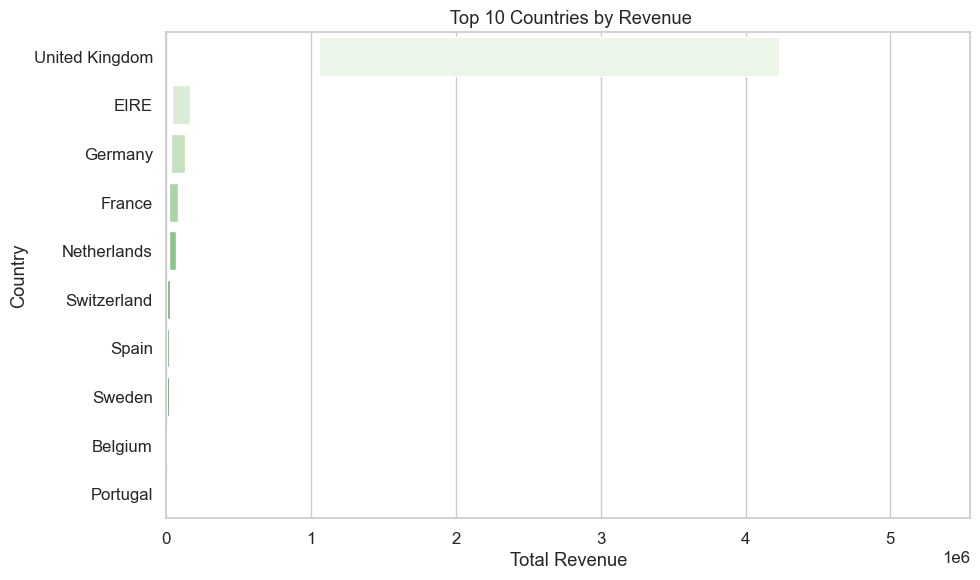

In [32]:
# Sum total revenue per country
revenue_by_country = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=revenue_by_country.values, y=revenue_by_country.index, palette="Greens")

# Slim the bars
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)

plt.title(" Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


📌 Observation:

The United Kingdom dominates in total revenue, aligning with the number of orders.

Countries like the Netherlands, EIRE (Ireland), and Germany also contribute significantly to the revenue stream.

#####  RFM Customer Segmentation

This step calculates key metrics for each customer to perform RFM segmentation, which helps in identifying customer behavior:

Recency: Days since the last purchase

Frequency: Number of unique transactions

Monetary: Total amount spent


In [33]:
import datetime as dt

# Reference date: one day after the last purchase in the data
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'Revenue': 'sum'                                           # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Display RFM table
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1297.97
2,12348.0,74,1,222.16
3,12349.0,43,3,2011.34
4,12351.0,11,1,295.68


📌 Observation:
The resulting RFM table provides a customer-wise summary of how recently, how often, and how much they purchased. This will be used in the next step for customer segmentation.

This step visualizes the top 10 customers based on the RFM metrics using a heatmap. It helps identify customers with high frequency, recent purchases, and high spending.

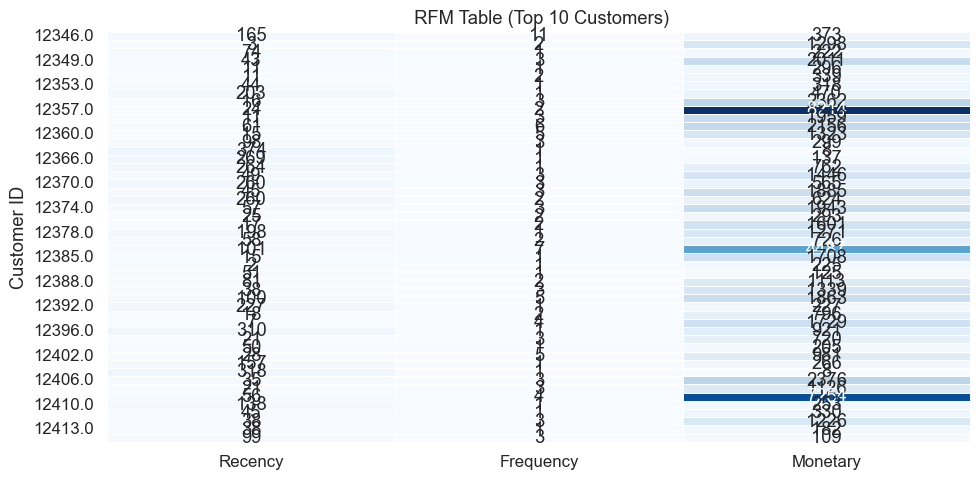

In [34]:
# Pick top 10 customers
rfm_table = rfm.head(50).set_index('Customer ID')[['Recency', 'Frequency', 'Monetary']]

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(rfm_table, annot=True, fmt=".0f", cmap='Blues', linewidths=0.5, cbar=False)
plt.title(" RFM Table (Top 10 Customers)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📌 Observation:

Darker shades represent higher values.

You can easily spot loyal and high-value customers (low recency, high frequency, and high monetary).



In this step, we assign scores to each customer based on Recency, Frequency, and Monetary values. Quartiles are used to rank customers into 4 segments (1 = lowest, 4 = highest).
We then combine the R, F, and M scores into a 3-digit RFM score (e.g., 443, 321).

In [35]:
# Assign scores using quartiles (qcut automatically handles binning)
rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1]).astype(int)  # Lower is better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

# Create RFM Segment Code
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Display top
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,165,11,372.86,1,4,2,142
1,12347.0,3,2,1297.97,4,2,3,423
2,12348.0,74,1,222.16,2,1,1,211
3,12349.0,43,3,2011.34,3,3,4,334
4,12351.0,11,1,295.68,4,1,2,412


📌 Observation:

RFM scores help categorize customers.

Example: A customer with score 444 is considered most loyal and valuable.

Using the RFM scores, we classify customers into segments such as Top Customer, Loyal Customer, Recent Customer, Frequent Buyer, Big Spender, and Others. This helps in targeting marketing strategies effectively.

In [36]:
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Top Customer'
    elif row['R'] >= 3 and row['F'] >= 3:
        return 'Loyal Customer'
    elif row['R'] >= 3:
        return 'Recent Customer'
    elif row['F'] >= 3:
        return 'Frequent Buyer'
    elif row['M'] >= 3:
        return 'Big Spender'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


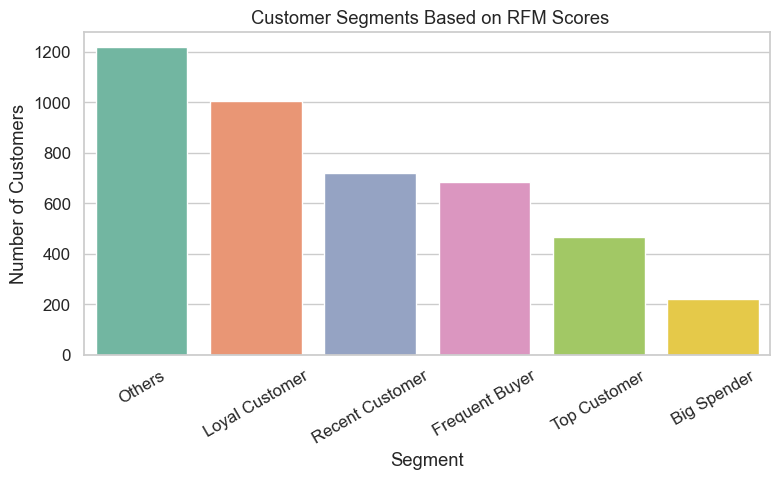

In [37]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title(' Customer Segments Based on RFM Scores')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


📌 Observation:

Majority of customers fall under the Loyal Customer and Others segments.

This segmentation can guide targeted marketing and promotional efforts.



This scatter plot helps visualize the distribution of customers based on Recency and Frequency, color-coded by their assigned RFM segment.

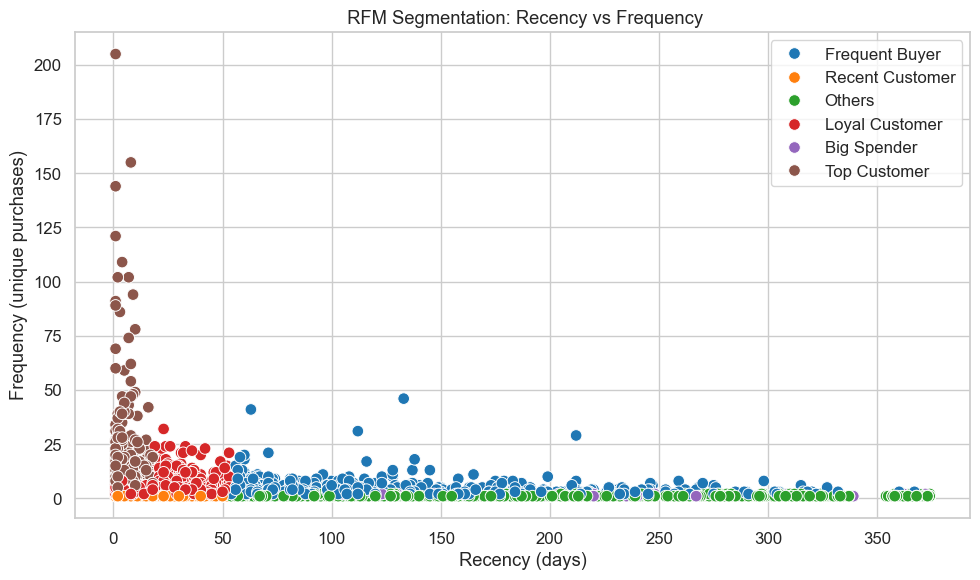

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10', s=70)
plt.title(' RFM Segmentation: Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (unique purchases)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


📌 Observation:

Top and Loyal Customers generally have lower recency (recent purchases) and higher frequency, showing strong engagement.

Recent Customers are low in recency but not necessarily frequent buyers.

Others are scattered with less frequent and older activity.



In [39]:
# Export full cleaned dataset
df.to_csv("cleaned_online_retail.csv", index=False)

# Optional: Export RFM table if needed separately
rfm.to_csv("rfm_segments.csv", index=False)